In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


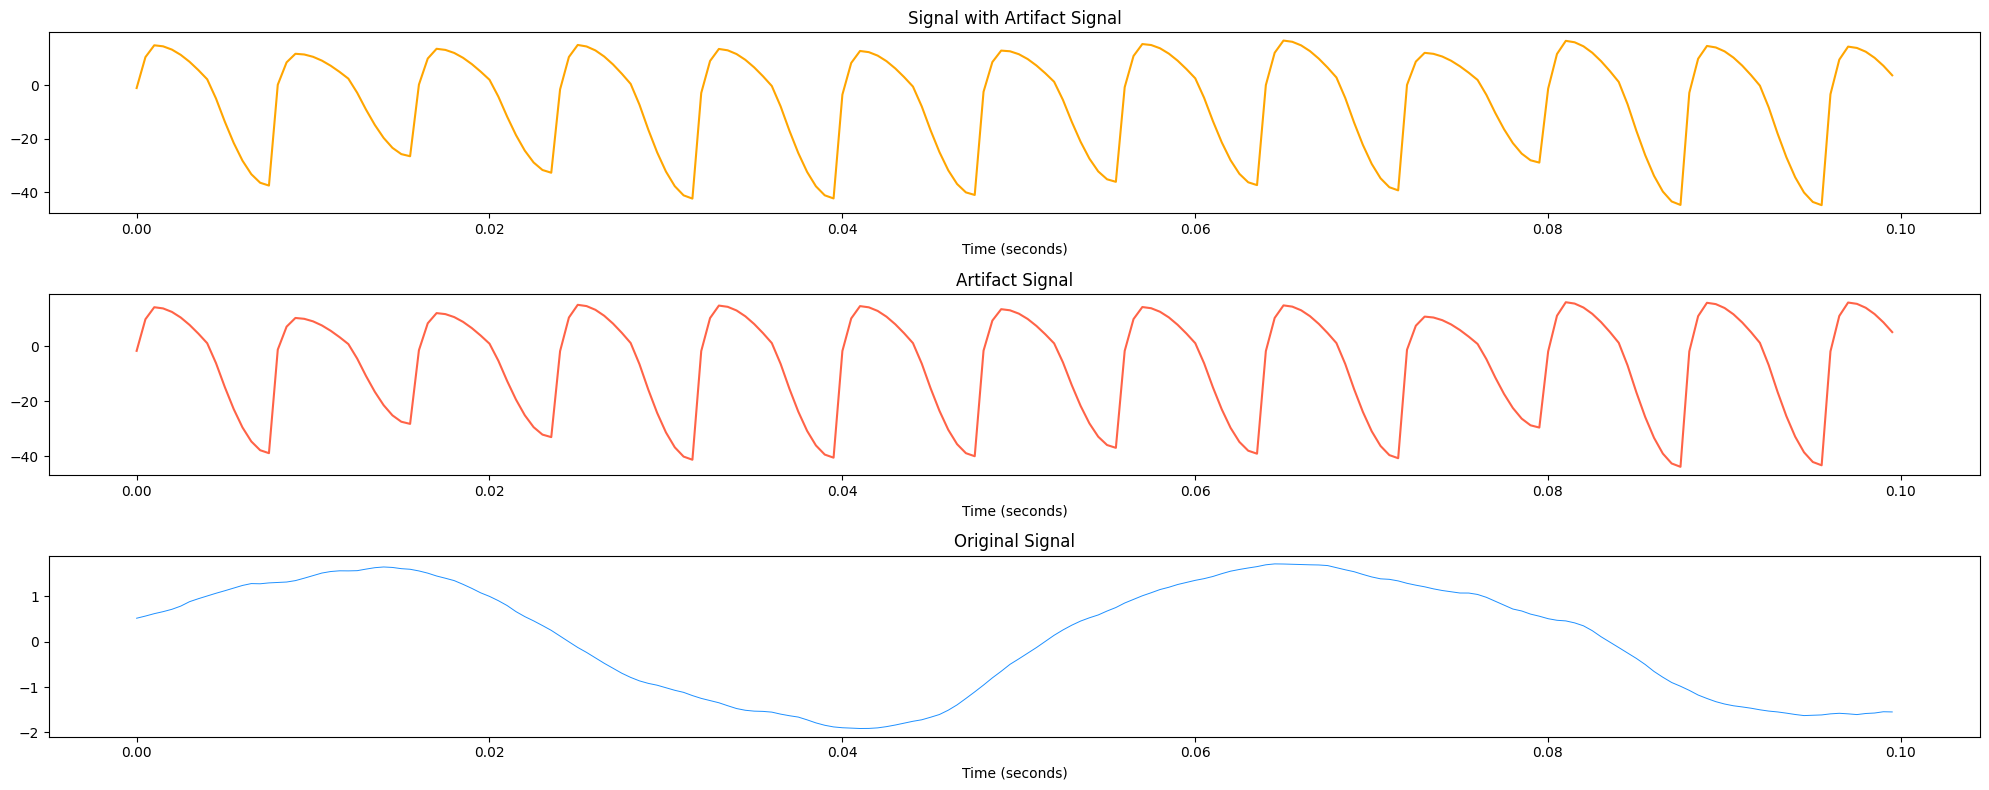

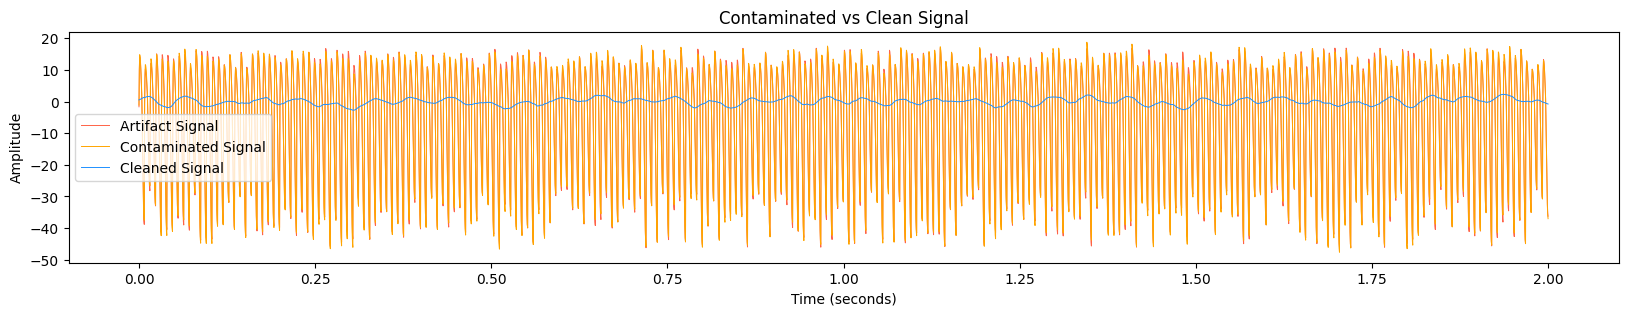

In [3]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange');plt.xlabel("Time (seconds)");plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato');plt.xlabel("Time (seconds)");plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue', linewidth = 0.7);plt.xlabel("Time (seconds)");plt.title('Original Signal')
# plt.xlim(0.0270, 0.0280)
# plt.ylim(-0.75, -0.65)

plt.tight_layout()

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

(1000, 4000)
(1000, 4000)
(1000, 2001)
(1000, 2001)
(2001,)


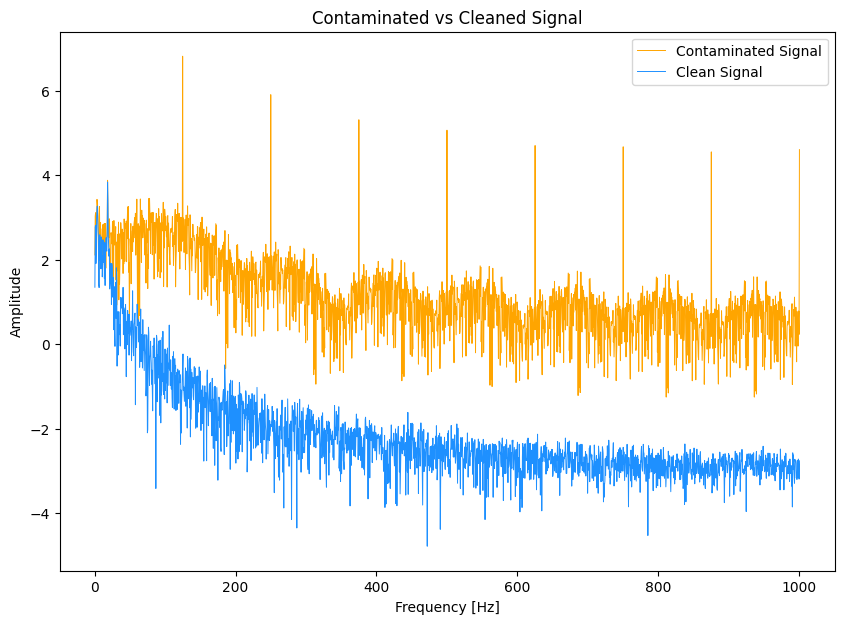

In [4]:
# z-score normalization
scaler = StandardScaler()

sig_with_artifact = scaler.fit_transform(sig_with_artifact.T)
sig = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

sig_with_artifact = sig_with_artifact.T; sig = sig.T

print(sig_with_artifact.shape)
print(sig.shape)

# power spectrum으로 변환
n = len(sig_with_artifact[0])

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(sig_with_artifact, axis=1)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(sig, axis=1)
power_clean = np.abs(fft_clean)**2

print(power_contaminated.shape)
print(power_clean.shape)
print(freqs.shape)

plt.figure(figsize=(10, 7))
plt.plot(freqs[1:], np.log10(power_contaminated[0][1:]), label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], np.log10(power_clean[0][1:]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude');plt.title('Contaminated vs Cleaned Signal');plt.legend();plt.show()

In [5]:
# Data preprocessing
X = sig_with_artifact
y = sig

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x F, y : B x F
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("unsqueezed X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x F, y : B x F
print("unsqueezed X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000)
y_train shape: (800, 4000)
X_test shape: (200, 4000)
y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)


In [6]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class simpleLSTM1d(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x).squeeze(-1) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [7]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = simpleLSTM1d(input_size, hidden_size, output_size, num_layers).to(device)
print(model)

simpleLSTM1d(
  (dropout): Dropout(p=0.1, inplace=False)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [8]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_fft_real, y_fft_real, y_pred_fft_img, y_fft_img):
        signal_loss = self.mse_loss(y_pred, y)
        fft_loss_real = self.mse_loss(y_pred_fft_real, y_fft_real)
        fft_loss_img = self.mse_loss(y_pred_fft_img, y_fft_img)
        fft_loss =fft_loss_real+fft_loss_img
        return self.alpha * signal_loss + (1 - self.alpha) * fft_loss

In [9]:
# 손실 함수와 옵티마이저 정의
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 200
epsilon = 1e-10 

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.shape
        y = y.view(batch_size, -1)
        y_pred = y_pred.view(batch_size, -1)
        
        y_fft = torch.fft.fft(y, dim=1)
        y_pred_fft = torch.fft.fft(y_pred, dim=1)

        y_fft_real = torch.log1p(y_fft.real.abs())
        y_fft_img = torch.log1p(y_fft.imag.abs())
        y_pred_fft_real = torch.log1p(y_pred_fft.real.abs())
        y_pred_fft_img = torch.log1p(y_pred_fft.imag.abs())

        # y_fft_real = torch.log10(y_fft.real.abs() + epsilon)
        # y_fft_img = torch.log10(y_fft.imag.abs()+ epsilon)
        # y_pred_fft_real = torch.log10(y_pred_fft.real.abs()+ epsilon)
        # y_pred_fft_img = torch.log10(y_pred_fft.imag.abs()+ epsilon)

        loss = criterion(y_pred, y, y_pred_fft_real, y_fft_real, y_pred_fft_img, y_fft_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.052902158349752426
Epoch 10/200, Loss: 0.04855366423726082
Epoch 15/200, Loss: 0.04842858761548996
Epoch 20/200, Loss: 0.04815911129117012
Epoch 25/200, Loss: 0.04663405194878578
Epoch 30/200, Loss: 0.04190683364868164
Epoch 35/200, Loss: 0.04110920801758766
Epoch 40/200, Loss: 0.037939950823783875
Epoch 45/200, Loss: 0.03751529008150101
Epoch 50/200, Loss: 0.038091521710157394
Epoch 55/200, Loss: 0.037590283900499344
Epoch 60/200, Loss: 0.03776198998093605
Epoch 65/200, Loss: 0.03834350407123566
Epoch 70/200, Loss: 0.039063915610313416
Epoch 75/200, Loss: 0.03861048072576523
Epoch 80/200, Loss: 0.03858330473303795
Epoch 85/200, Loss: 0.03868037462234497
Epoch 90/200, Loss: 0.03795544058084488
Epoch 95/200, Loss: 0.038179222494363785
Epoch 100/200, Loss: 0.03869728371500969
Epoch 105/200, Loss: 0.03617234155535698
Epoch 110/200, Loss: 0.0405612476170063
Epoch 115/200, Loss: 0.037796102464199066
Epoch 120/200, Loss: 0.037944432348012924
Epoch 125/200, Loss: 0.038121

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro_real = torch.tensor([])
SACed_spectro_img = torch.tensor([])
Clean_spectro_real = torch.tensor([])
Clean_spectro_img = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.shape
        y = y.view(batch_size, -1)
        y_pred = y_pred.view(batch_size, -1)
        
        y_fft = torch.fft.fft(y, dim=1)
        y_pred_fft = torch.fft.fft(y_pred, dim=1)
        
        y_fft_real = torch.log1p(y_fft.real.abs())
        y_fft_img = torch.log1p(y_fft.imag.abs())
        y_pred_fft_real = torch.log1p(y_pred_fft.real.abs())
        y_pred_fft_img = torch.log1p(y_pred_fft.imag.abs())

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)
        SACed_spectro_real = torch.cat((SACed_spectro_real, y_pred_fft_real.cpu()), 0)
        SACed_spectro_img = torch.cat((SACed_spectro_img, y_pred_fft_img.cpu()), 0)
        Clean_spectro_real = torch.cat((Clean_spectro_real, y_fft_real.cpu()), 0)
        Clean_spectro_img = torch.cat((Clean_spectro_img, y_fft_img.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro_real, Clean_spectro_real, SACed_spectro_img, Clean_spectro_img)
print(f'Validation Loss: {val_loss.item()}')    
        

Validation Loss: 0.03691647946834564


Mean Absolute Error: 0.04796476662158966
Mean Squared Error: 0.004127591382712126


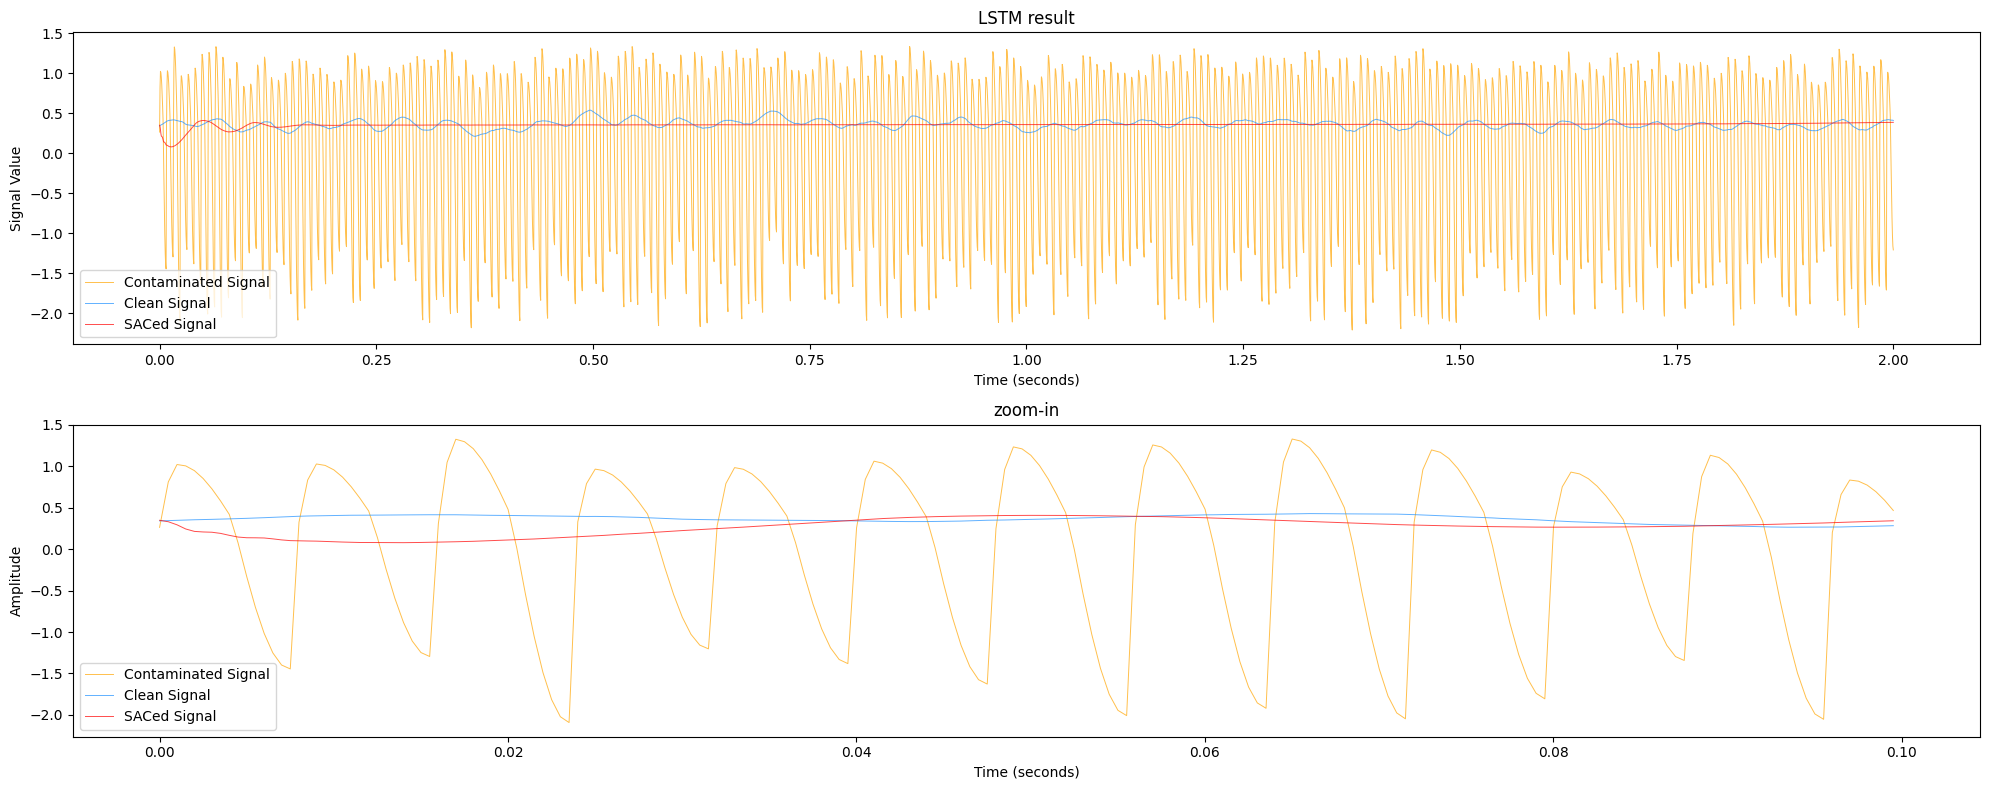

In [11]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('LSTM result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

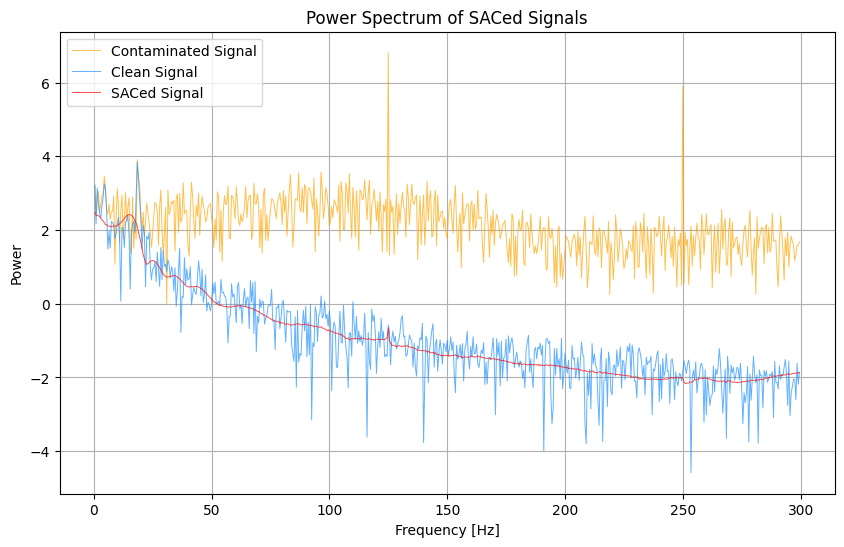

Mean Absolute Error: 0.4994763171830061
Mean Squared Error: 0.3564997139027438


In [12]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(Contaminated_signal)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(Clean_signal)
power_clean = np.abs(fft_clean)**2

fft_SACed = np.fft.rfft(SACed_signal)
power_SACed = np.abs(fft_SACed)**2

plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_contaminated)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_clean)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_SACed)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of SACed Signals')
plt.xlabel('Frequency [Hz]');plt.ylabel('Power');plt.legend();plt.grid(True);plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_SACed), np.log10(power_clean))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_SACed), np.log10(power_clean))}")